In [1054]:
import numpy as np
from matplotlib import pyplot as plt
from abc import ABCMeta, abstractmethod
from optimizers import SGD
from sghmc import SGHMC
import pandas as pd
from sklearn.linear_model import Ridge
%matplotlib inline

In [362]:
class SGD(SGDBase):
    
    def __init__(self,
                 grad_objective,
                 eta=0.01, batch_size=100,
                 epochs=10, seed=None, 
                 alpha=0, save_trajectory=False):
        
        SGDBase.__init__(self, 
                         grad_objective,
                         eta=eta,
                         batch_size=batch_size,
                         epochs=epochs,
                         seed=seed)
        self.alpha = alpha
        self.save_trajectory = save_trajectory
        if self.save_trajectory:
            self.w_values = []
        self._trained = False
    
    def _next_direction(self, X, y=None):
        
        res = self.alpha * self.velocity
        
        if y is None:
            return res - self.eta * self.batch_counts * self.grad_objective(self.w, X)
        else:
            return res - self.eta * self.batch_counts * self.grad_objective(self.w, X, y)
        
    
    def step(self, X, w_init=None, y=None, batch_counts=None):
        self.num_objects, num_features = X.shape
        if not self._trained:
            self.batch_counts = batch_counts
            if w_init is not None:
                self.w = w_init
            else:
                self.w = np.zeros(num_features)
            self.velocity = np.zeros(num_features)
            self._trained = True
        self.velocity = self._next_direction(X, y=y)
        self.w = self.w + self._next_direction(X, y=y)
        if self.save_trajectory:
            self.w_values.append(self.w)
        return self.w
    
    
    def train(self, X, y=None, w_init=None, display=False):
        
        self.num_objects, num_features = X.shape
        self.batch_counts = self.num_objects // self.batch_size
        indices = np.arange(num_objects)
        self._trained = True
        if w_init is None:
            self.w = np.zeros(num_features)
        else:
            self.w = w_init
        self.velocity = np.zeros(num_features)
        for epoch in range(self.epochs):
            mini_batches = np.random.choice(indices, size=self.num_objects, replace=False)
            for batch in range(self.batch_counts):
                batch_ind = mini_batches[batch * self.batch_size: (batch + 1) * self.batch_size]
                X_batch = X[batch_ind, :]
                if y is not None:
                    y_batch = y[batch_ind]
                else:
                    y_batch = None
                self.w = self.step(X_batch, y=y_batch)
                
            if display and (epoch % 100 == 0):
                print(epoch)
                    
        return

In [964]:
class SGHMC(object):
    
    def __init__(self,
                 grad_objective,
                 eta=0.01, batch_size=100,
                 epochs=10, seed=None, 
                 alpha=0):
        
        self.optimizer = SGD(grad_objective, 
                             eta=eta, 
                             epochs=epochs,
                             batch_size=batch_size,
                             seed=seed,
                             alpha=1. - alpha)
        self.batch_size = batch_size
        self.seed = seed
        self.epochs = epochs
        
    def samples_return(self, X, w_init=None, y=None, display=False):
        np.random.seed(self.seed)
        self.num_objects, num_features = X.shape
        self.batch_counts = self.num_objects // self.batch_size
        indices = np.arange(num_objects)
        iterations_cnt = self.batch_counts * self.epochs
        self.samples = np.zeros((iterations_cnt, num_features))
        self.noise_cov = np.zeros((num_features, num_features))
        self.noise_cov[0, 0] = self.noise_cov[1, 1] =  2 * self.optimizer.eta * self.optimizer.alpha
        noise = np.random.multivariate_normal(np.zeros(num_features), self.noise_cov, size=iterations_cnt)
        for epoch in range(self.epochs):
            mini_batches = np.random.choice(indices, size=self.num_objects, replace=False)
            for batch in range(self.batch_counts):
                batch_ind = mini_batches[batch * self.batch_size: (batch + 1) * self.batch_size]
                X_batch = X[batch_ind, :]
                if y is not None:
                    y_batch = y[batch_ind]
                else:
                    y_batch = None
                i = epoch * self.batch_counts + batch
                self.optimizer.w = self.optimizer.step(X_batch, w_init=w_init, y=y_batch, 
                                                       batch_counts=self.num_objects / self.batch_size)
                self.optimizer.w += noise[i, :]
                self.samples[i, :] = self.optimizer.w
            if display and (epoch % 100 == 0):
                print(epoch)                          
        return self.samples

## Simple Gaussian.

$$p(w) = \mathcal{N}(w|0, 2I) = \frac{1}{2 \pi^{1/2}} exp(-1/4 w^T w)$$
$$p(x|w) = \mathcal{N}(x|w, I) = \frac{1}{(2 \pi)^{1/2}} exp\big(-1/2 (x - w)^T (x - w)\big)$$
$$p(w|X) \propto p(w)p(X|w)$$
$$N=10000$$

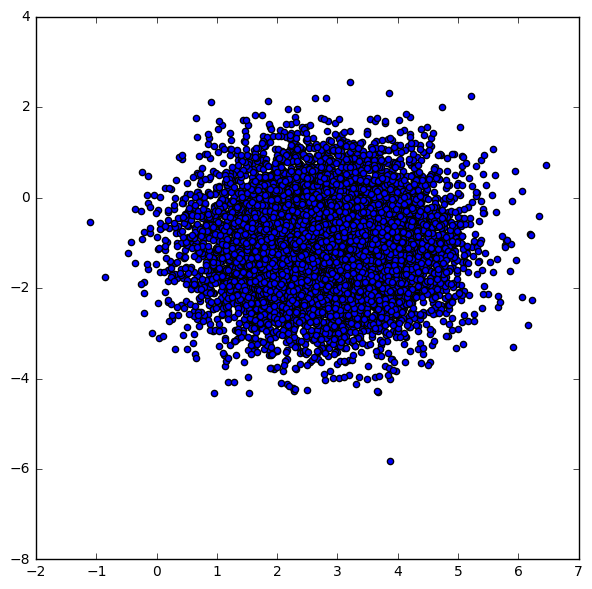

In [1039]:
num_features = 2
num_objects = 10000
prior_std = 2.

w_true = np.sqrt(prior_std) * np.random.randn(num_features)
X = w_true + np.random.randn(num_objects, num_features)

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c='b')

In [1040]:
def grad(w, X):
    return 0.5 * w - (X - w).sum(axis=0)

### True posterior.

$$C_{w|X} = \frac{1}{(N + 1/2)} I$$
$$\mu_{w|X} = \frac{1}{(N + 1/2)} \sum_{i=1}^N x_i$$

In [1041]:
cov_w_X = 1. / (num_objects + 0.5) * np.eye(num_features)
mean_w_X = 1. / (num_objects + 0.5) * X.sum(axis=0)

w_posterior = np.random.multivariate_normal(mean_w_X, cov_w_X, size=4000)

### Samples from SGHMC.

In [1042]:
%%time
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

samples_1 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))
w_start = np.random.multivariate_normal(np.zeros(num_features), 
                                        prior_std * np.eye(num_features))
w_start = mean_w_X

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=1.0, epochs=epoch_cnt, batch_size=batch_size)
        batch_cnt = num_objects // batch_size
        samples_1[i, j, :, :] = sampler.samples_return(X, w_init=w_start)[::batch_cnt, :]
    print("eta: ", eta)

eta:  0.0001
eta:  1e-05
eta:  1e-06
eta:  1e-07
eta:  5e-08
CPU times: user 2min 30s, sys: 38.3 ms, total: 2min 30s
Wall time: 2min 30s


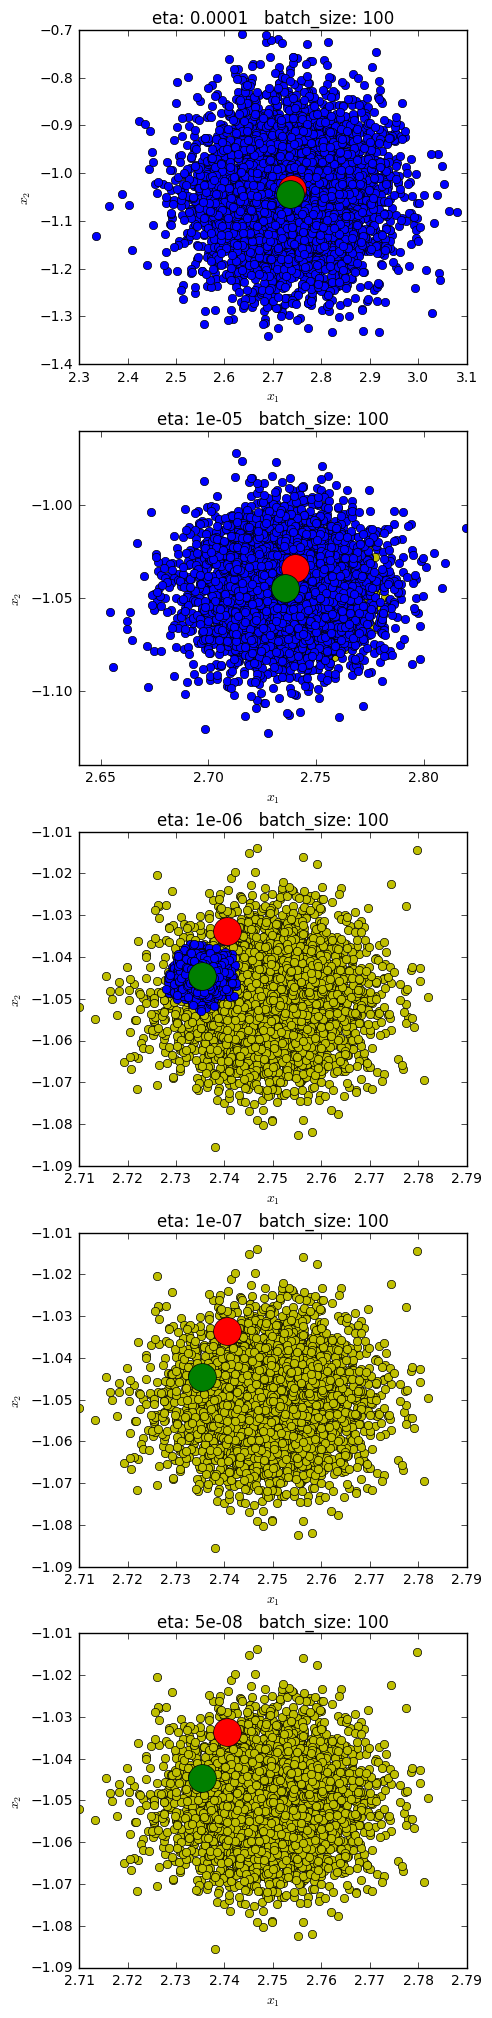

In [1045]:
f, axxr = plt.subplots(5, 1)
f.set_figheight(25)
f.set_figwidth(5)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        axxr[i].plot(w_posterior[:, 0], w_posterior[:, 1], 'yo')
        axxr[i].plot(samples_1[i, j, 100:, 0], samples_1[i, j, 100:, 1], 'bo')
        axxr[i].plot(w_true[0], w_true[1],'ro', markersize=20)
        sghmc_mean = samples_1[i, j, :, :].mean(axis=0)
        axxr[i].plot(sghmc_mean[0], sghmc_mean[1],'go', markersize=20)
        axxr[i].set_xlabel('$x_1$')
        axxr[i].set_ylabel('$x_2$')
#plt.legend(['True posterior', 
#            'SGHMC samples',
#           'w_true',
#           'sghmc mean'], bbox_to_anchor=(0.0, -0.5), prop={'size': 30})

In [986]:
%%time
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

samples_1 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))
w_start = np.random.multivariate_normal(np.zeros(num_features), 
                                        prior_std * np.eye(num_features))

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=1, epochs=epoch_cnt, batch_size=batch_size)
        batch_cnt = num_objects // batch_size
        samples_1[i, j, :, :] = sampler.samples_return(X, w_init=w_start)[::batch_cnt, :]
    print("eta: ", eta)

eta:  0.0001
eta:  1e-05
eta:  1e-06
eta:  1e-07
eta:  5e-08
CPU times: user 1min 54s, sys: 52.6 ms, total: 1min 54s
Wall time: 1min 54s


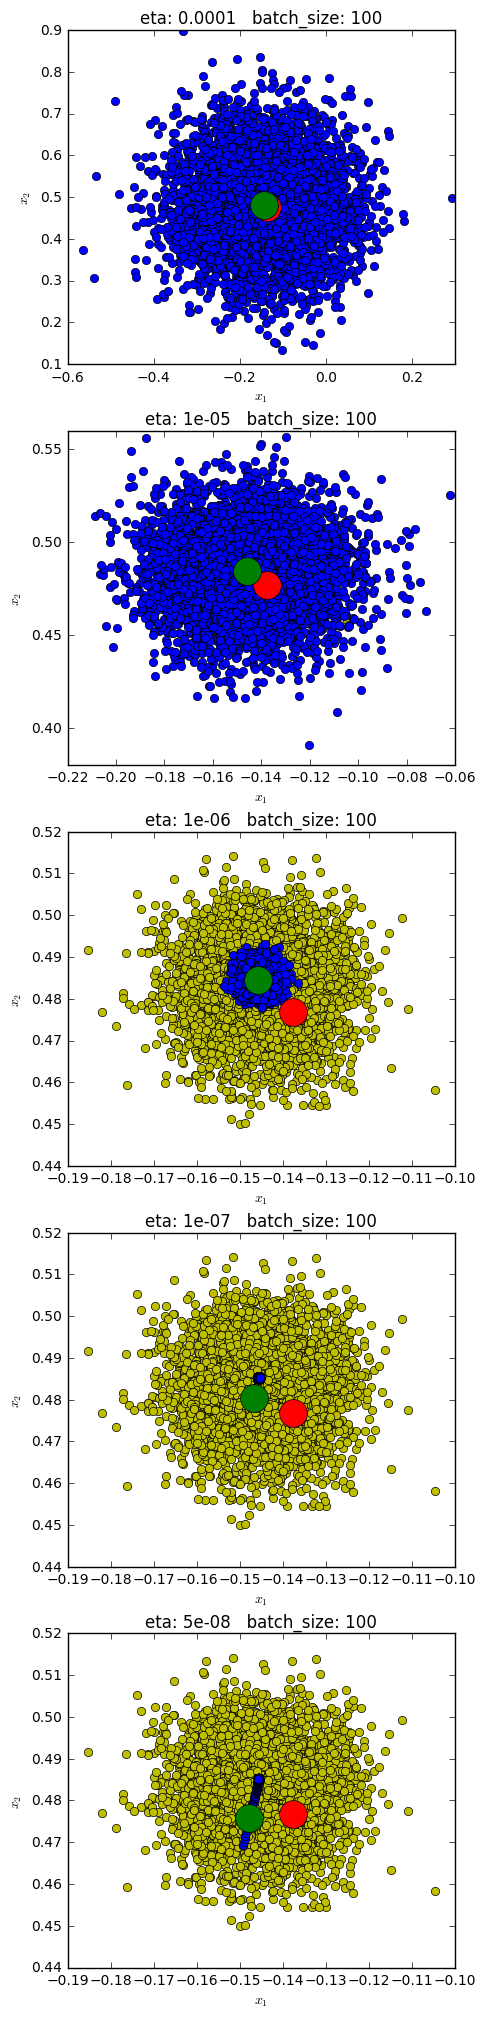

In [987]:
f, axxr = plt.subplots(5, 1)
f.set_figheight(25)
f.set_figwidth(5)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

for i, eta in enumerate(eta_params):
    
    axxr[i].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
    axxr[i].plot(w_posterior[:, 0], w_posterior[:, 1], 'yo')
    axxr[i].plot(samples_1[i, j, 100:, 0], samples_1[i, j, 100:, 1], 'bo')
    axxr[i].plot(w_true[0], w_true[1],'ro', markersize=20)
    sghmc_mean = samples_1[i, j, :, :].mean(axis=0)
    axxr[i].plot(sghmc_mean[0], sghmc_mean[1],'go', markersize=20)
    axxr[i].set_xlabel('$x_1$')
    axxr[i].set_ylabel('$x_2$')
#plt.legend(['True posterior', 
#            'SGHMC samples',
#           'w_true',
#           'sghmc mean'], bbox_to_anchor=(0.0, -0.5), prop={'size': 30})

In [931]:
%%time
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

samples_1 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))
w_start = np.random.multivariate_normal(np.zeros(num_features), 
                                        prior_std * np.eye(num_features))
w_start = mean_w_X

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=0.01, epochs=epoch_cnt, batch_size=batch_size)
        batch_cnt = num_objects // batch_size
        samples_1[i, j, :, :] = sampler.samples_return(X, w_init=w_start)[::batch_cnt, :]
    print("eta: ", eta)

eta:  0.0001
eta:  1e-05
eta:  1e-06
eta:  1e-07
eta:  5e-08
CPU times: user 1min 59s, sys: 51.1 ms, total: 1min 59s
Wall time: 1min 59s


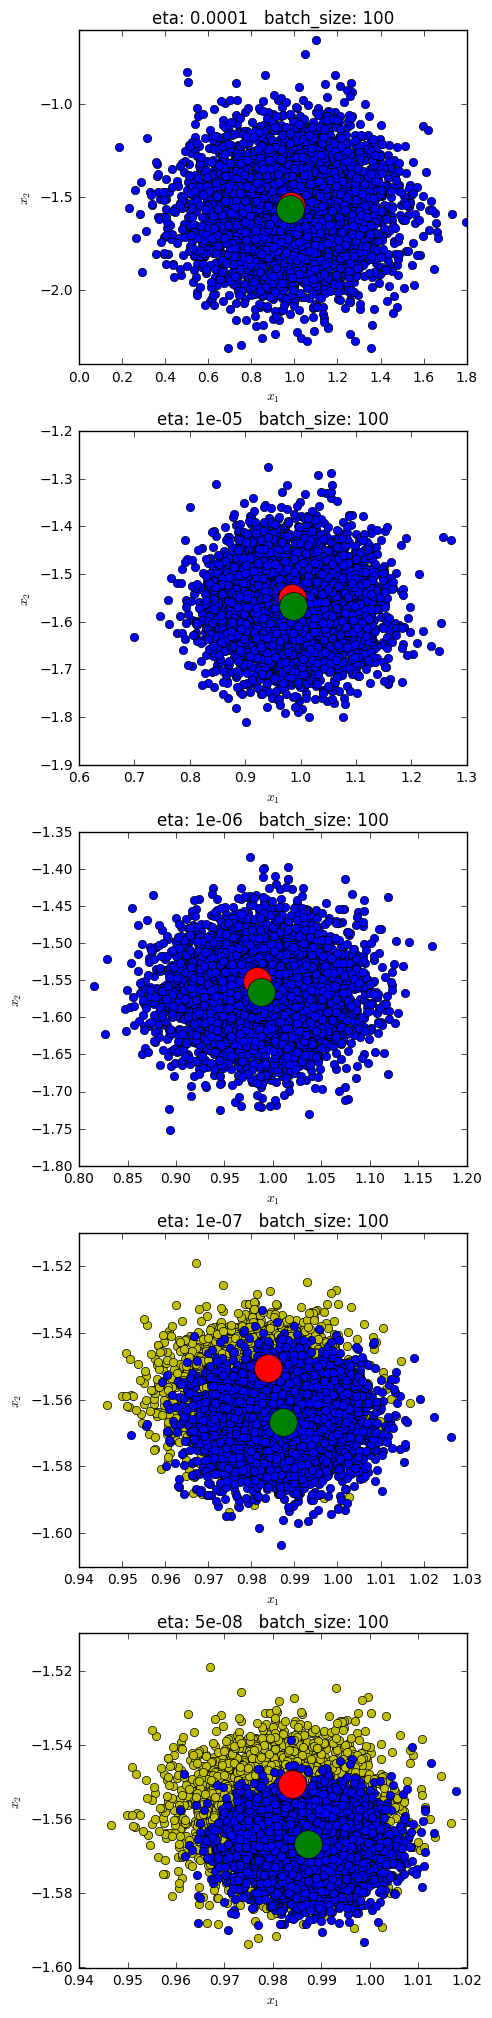

In [932]:
f, axxr = plt.subplots(5, 1)
f.set_figheight(25)
f.set_figwidth(5)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100]#, 500, 1000]
epoch_cnt = 5000

for i, eta in enumerate(eta_params):
    
    axxr[i].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
    axxr[i].plot(w_posterior[:, 0], w_posterior[:, 1], 'yo')
    axxr[i].plot(samples_1[i, j, 100:, 0], samples_1[i, j, 100:, 1], 'bo')
    axxr[i].plot(w_true[0], w_true[1],'ro', markersize=20)
    sghmc_mean = samples_1[i, j, :, :].mean(axis=0)
    axxr[i].plot(sghmc_mean[0], sghmc_mean[1],'go', markersize=20)
    axxr[i].set_xlabel('$x_1$')
    axxr[i].set_ylabel('$x_2$')
#plt.legend(['True posterior', 
#            'SGHMC samples',
#           'w_true',
#           'sghmc mean'], bbox_to_anchor=(0.0, -0.5), prop={'size': 30})

## 4d dimensional gaussian.

$$p(w) = \mathcal{N}(w|0, 2I)$$
$$p(x|w) = \mathcal{N}(x|w, I)$$
$$p(w|X) \propto p(w)p(X|w) = exp\big( \big)$$
$$N=10000$$

In [933]:
num_features = 4
num_objects = 10000
prior_std = 2.

w_true = np.sqrt(prior_std) * np.random.randn(num_features)
X = w_true + np.random.randn(num_objects, num_features)

### SGHMC sampler.

In [935]:
%%time
eta_params = [1e-5, 1e-6, 1e-7]
batch_size_params = [500, 1000]
epoch_cnt = 5000

samples_2 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))
w_start = np.random.multivariate_normal(np.zeros(num_features), 
                                        prior_std * np.eye(num_features))

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=0.01, epochs=epoch_cnt, batch_size=batch_size)
        batch_cnt = num_objects // batch_size
        samples_2[i, j, :, :] = sampler.samples_return(X, w_init=w_start)[::batch_cnt, :]
    print("eta: ", eta)

eta:  1e-05
eta:  1e-06
eta:  1e-07
CPU times: user 1min 18s, sys: 56.5 ms, total: 1min 18s
Wall time: 1min 18s


### True posterior.

In [940]:
cov_w_X = 1. / (num_objects + 0.5) * np.eye(num_features)
mean_w_X = 1. / (num_objects + 0.5) * X.sum(axis=0)

w_posterior = np.random.multivariate_normal(mean_w_X, cov_w_X, size=samples_cnt)

In [938]:
samples_cnt = samples_2[i, j, 100:, :].shape[0]

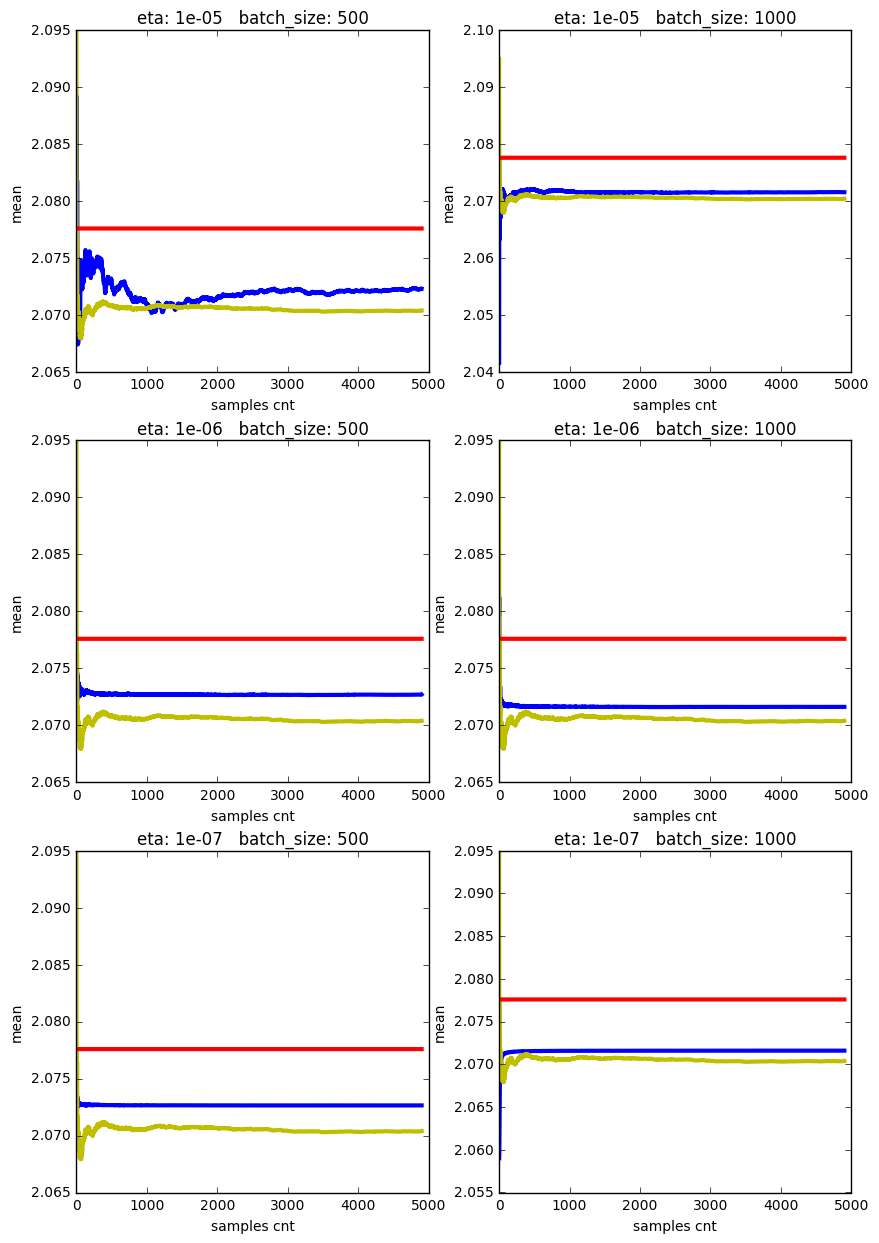

In [942]:
f, axxr = plt.subplots(3, 2)
f.set_figheight(15)
f.set_figwidth(10)
means_posterior = np.cumsum(w_posterior, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        #calculate means
        means_sghmc = np.cumsum(samples_2[i, j, 100:, :], axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        
        #axxr[i, j].set_yscale('log')
        
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_sghmc[:, 0], lw=3, c='b')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_posterior[:, 0], lw=3, c='y')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), w_true[0] * np.ones(samples_cnt), lw=3, c='r')
        
        axxr[i, j].set_xlabel('samples cnt')
        axxr[i, j].set_ylabel('mean')
#plt.legend(['Mean of sghmc samples',
#            'Means of posterior samples',
#           'w_true'], bbox_to_anchor=(0.0, -0.5), prop={'size': 20})

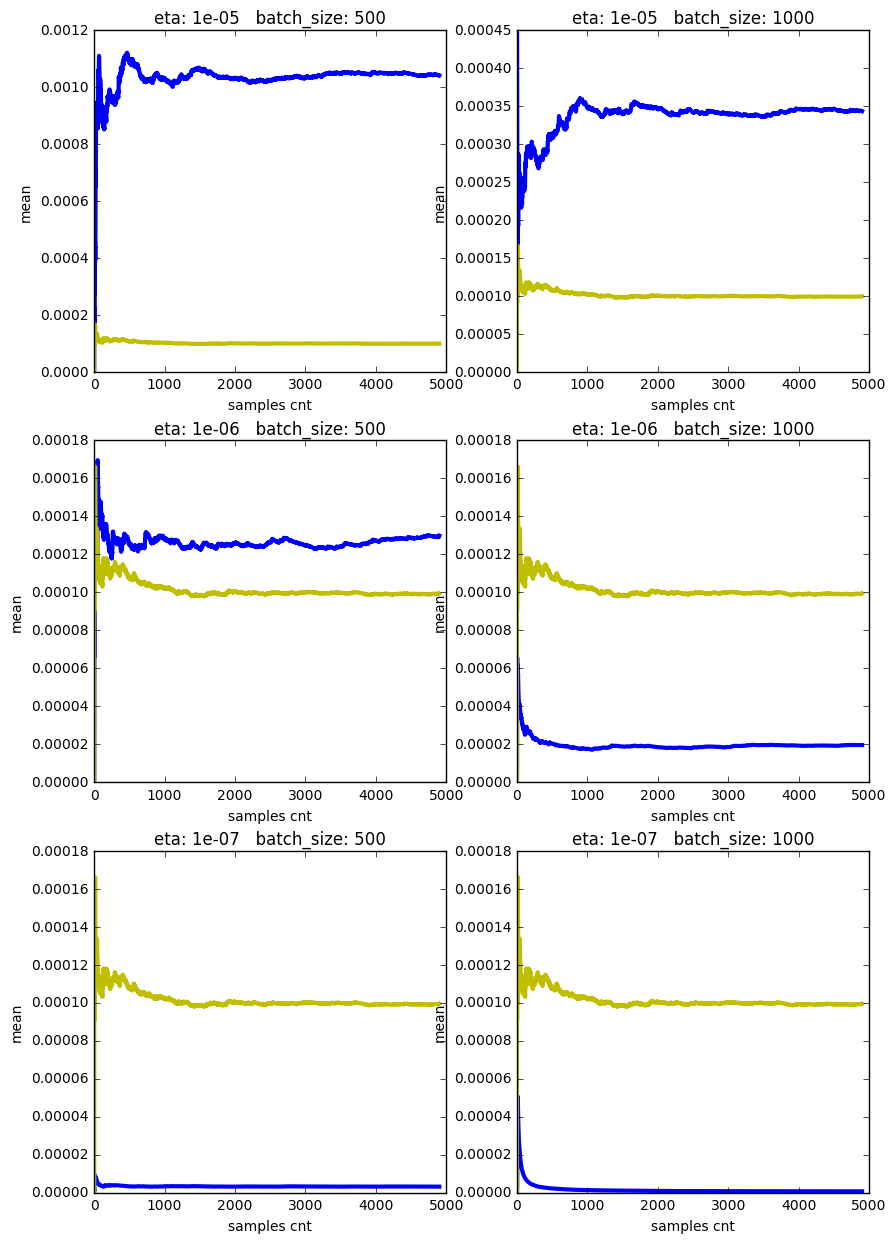

In [947]:
f, axxr = plt.subplots(3, 2)
f.set_figheight(15)
f.set_figwidth(10)
means_posterior = np.cumsum(w_posterior, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
means_posterior = np.cumsum((w_posterior - means_posterior) ** 2, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        samples_cnt = samples_2[i, j, 100:, :].shape[0]
        #calculate means
        means_sghmc = np.cumsum(samples_2[i, j, 100:, :], axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        means_sghmc = np.cumsum((samples_2[i, j, 100:, :] - means_sghmc) ** 2, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        
        #axxr[i, j].set_yscale('log')
        
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_sghmc[:, 0], lw=3, c='b')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_posterior[:, 0], lw=3, c='y')
        #axxr[i, j].plot(np.arange(1, samples_cnt + 1), w_true[0] * np.ones(samples_cnt), lw=3, c='r')
        
        axxr[i, j].set_xlabel('samples cnt')
        axxr[i, j].set_ylabel('mean')
#plt.legend(['Mean of sghmc samples',
#            'Means of posterior samples',
#           'w_true'], bbox_to_anchor=(0.0, -0.5), prop={'size': 20})

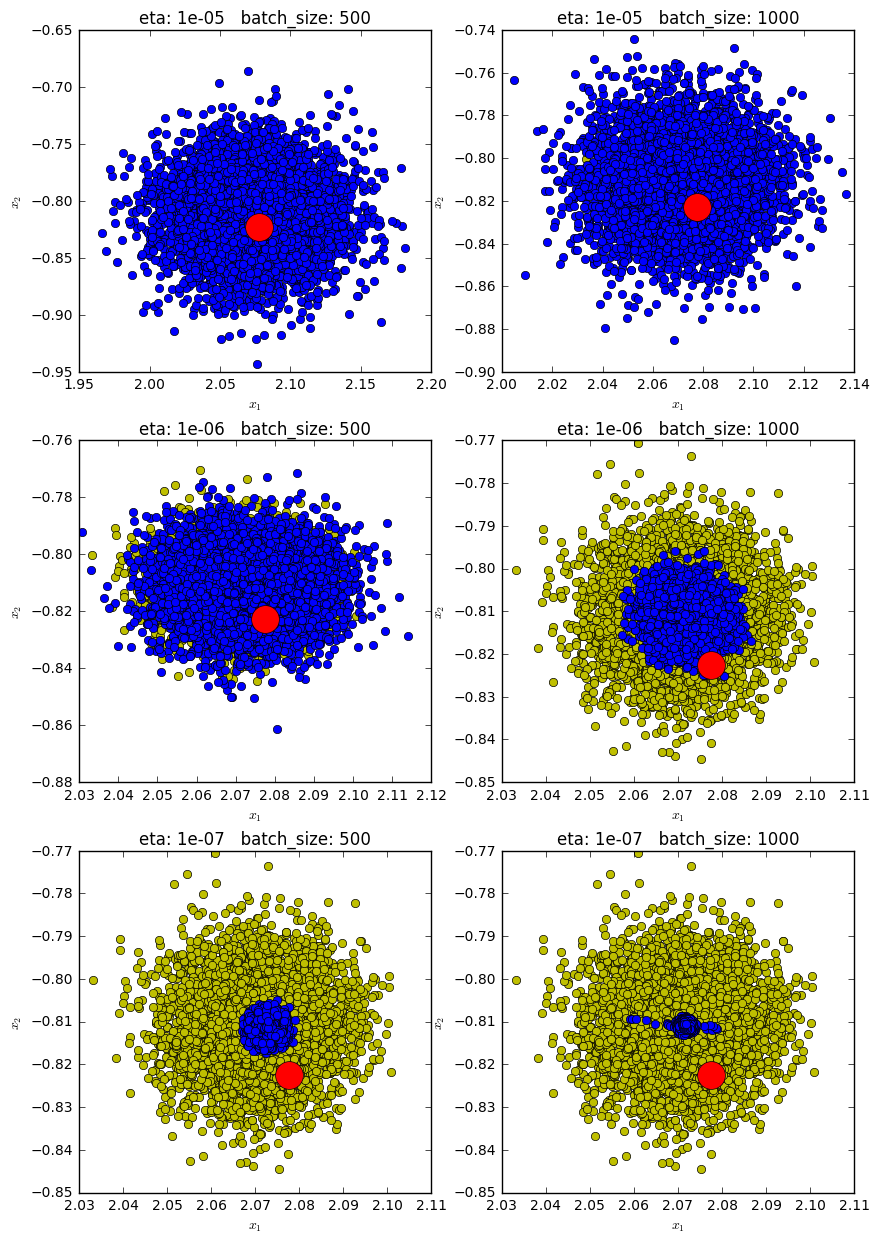

In [945]:
f, axxr = plt.subplots(3, 2)
f.set_figheight(15)
f.set_figwidth(10)
for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        axxr[i, j].plot(w_posterior[:, 0], w_posterior[:, 1], 'yo')
        axxr[i, j].plot(samples_2[i, j, 100:, 0], samples_2[i, j, 100:, 1], 'bo')
        axxr[i, j].plot(w_true[0], w_true[1],'ro', markersize=20)
        axxr[i, j].set_xlabel('$x_1$')
        axxr[i, j].set_ylabel('$x_2$')

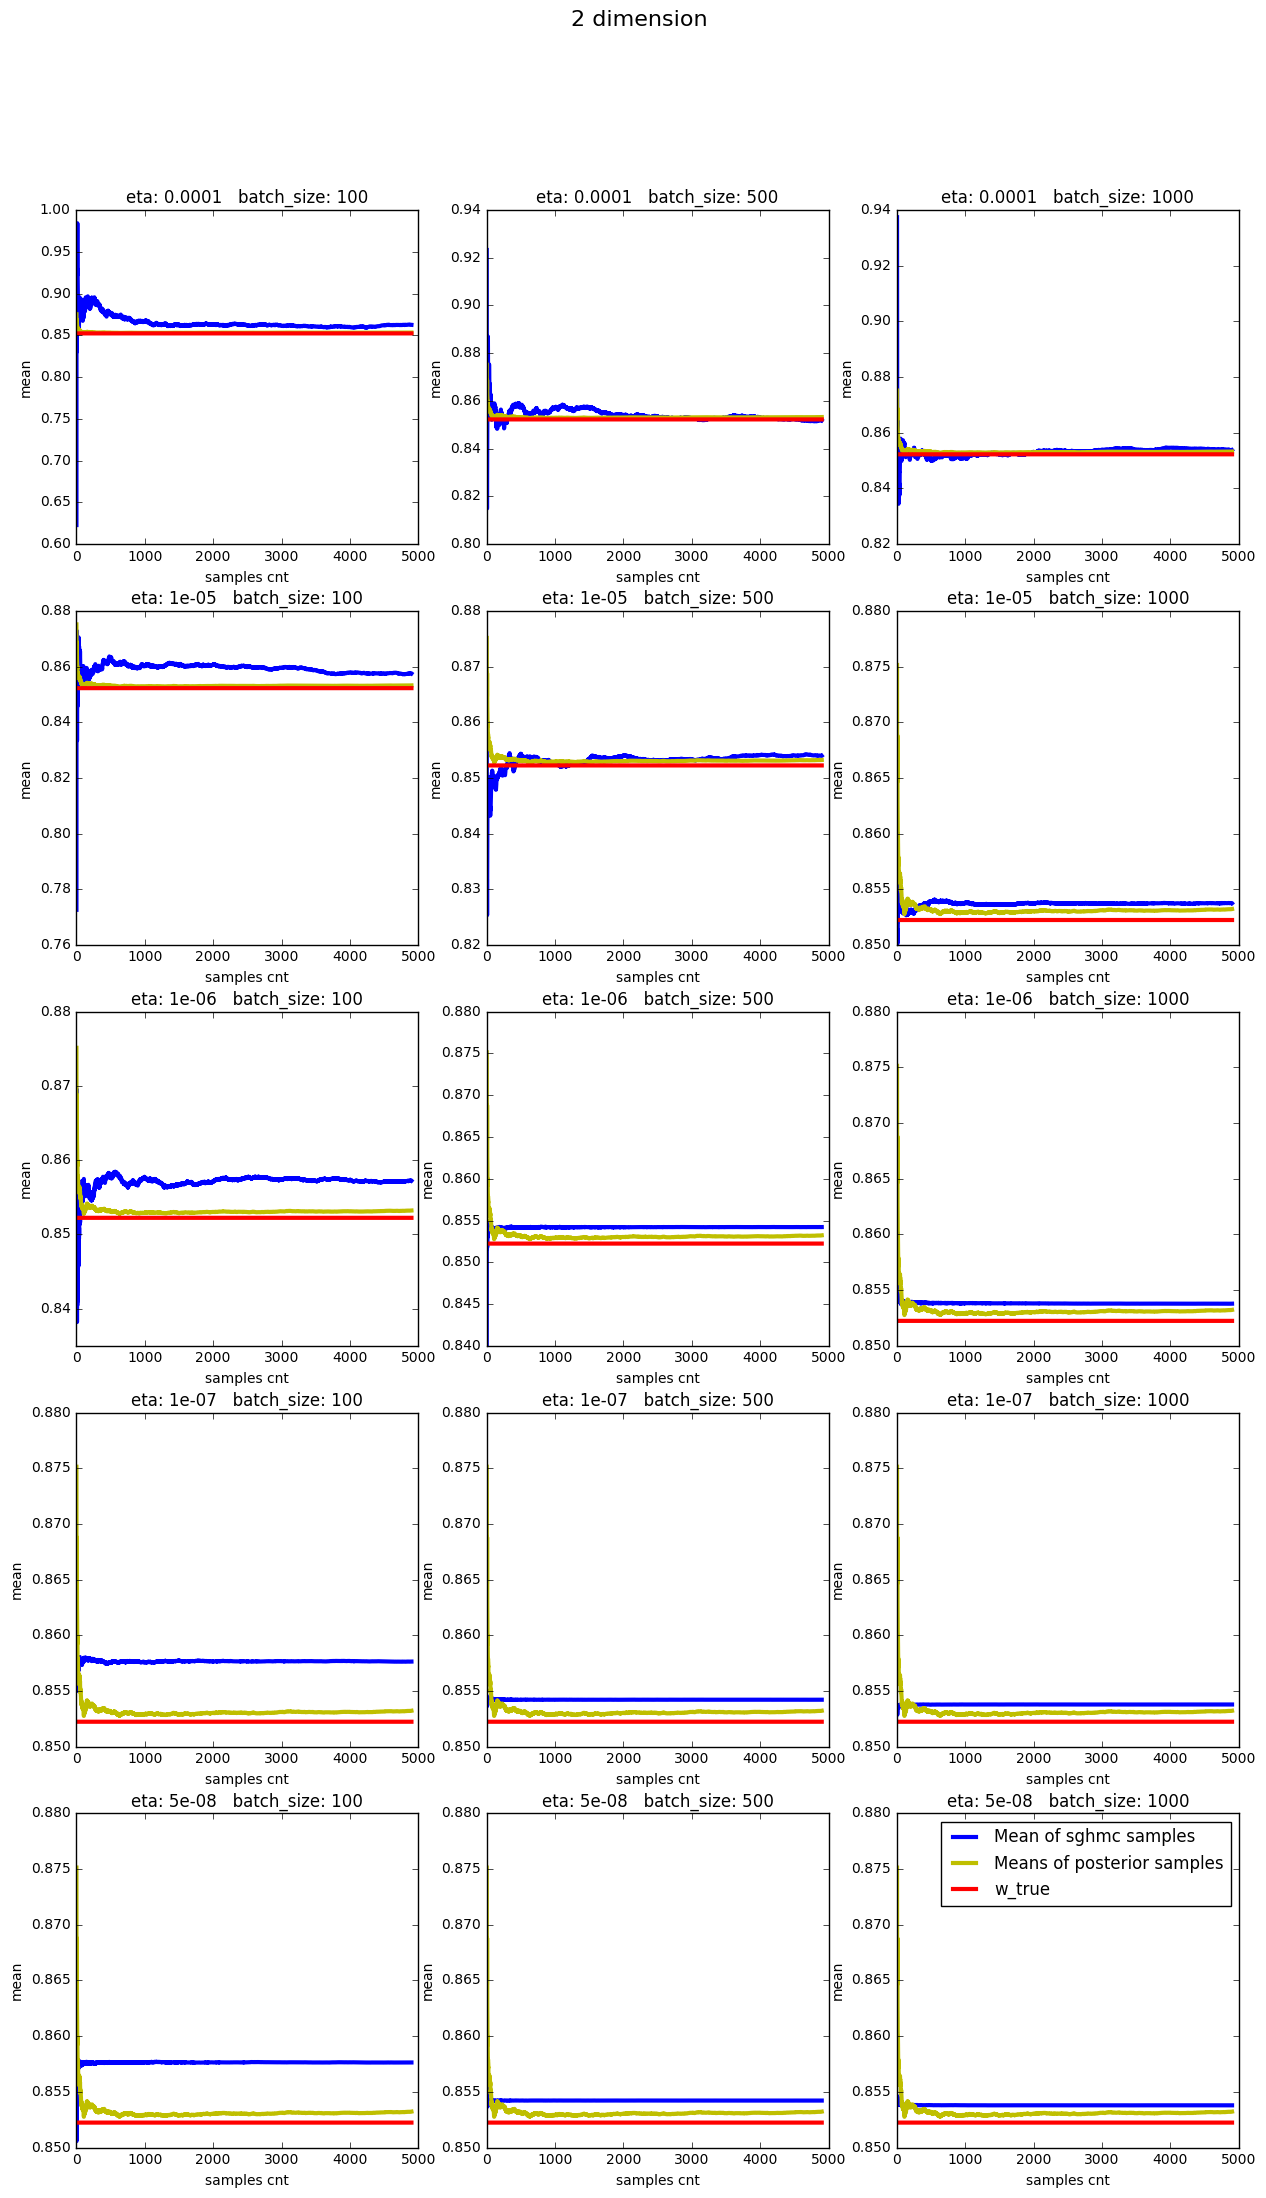

In [758]:
f, axxr = plt.subplots(5, 3)
f.set_figheight(25)
f.set_figwidth(15)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100, 500, 1000]
means_posterior = np.cumsum(w_posterior, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        samples_cnt = samples_2[i, j, 100:, :].shape[0]
        #calculate means
        means_sghmc = np.cumsum(samples_2[i, j, 100:, :], axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        
        #axxr[i, j].set_yscale('log')
        
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_sghmc[:, 1], lw=3, c='b')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_posterior[:, 1], lw=3, c='y')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), w_true[1] * np.ones(samples_cnt), lw=3, c='r')
        
        axxr[i, j].set_xlabel('samples cnt')
        axxr[i, j].set_ylabel('mean')
plt.legend(['Mean of sghmc samples',
            'Means of posterior samples',
           'w_true'])
f.suptitle('2 dimension', fontsize=16)

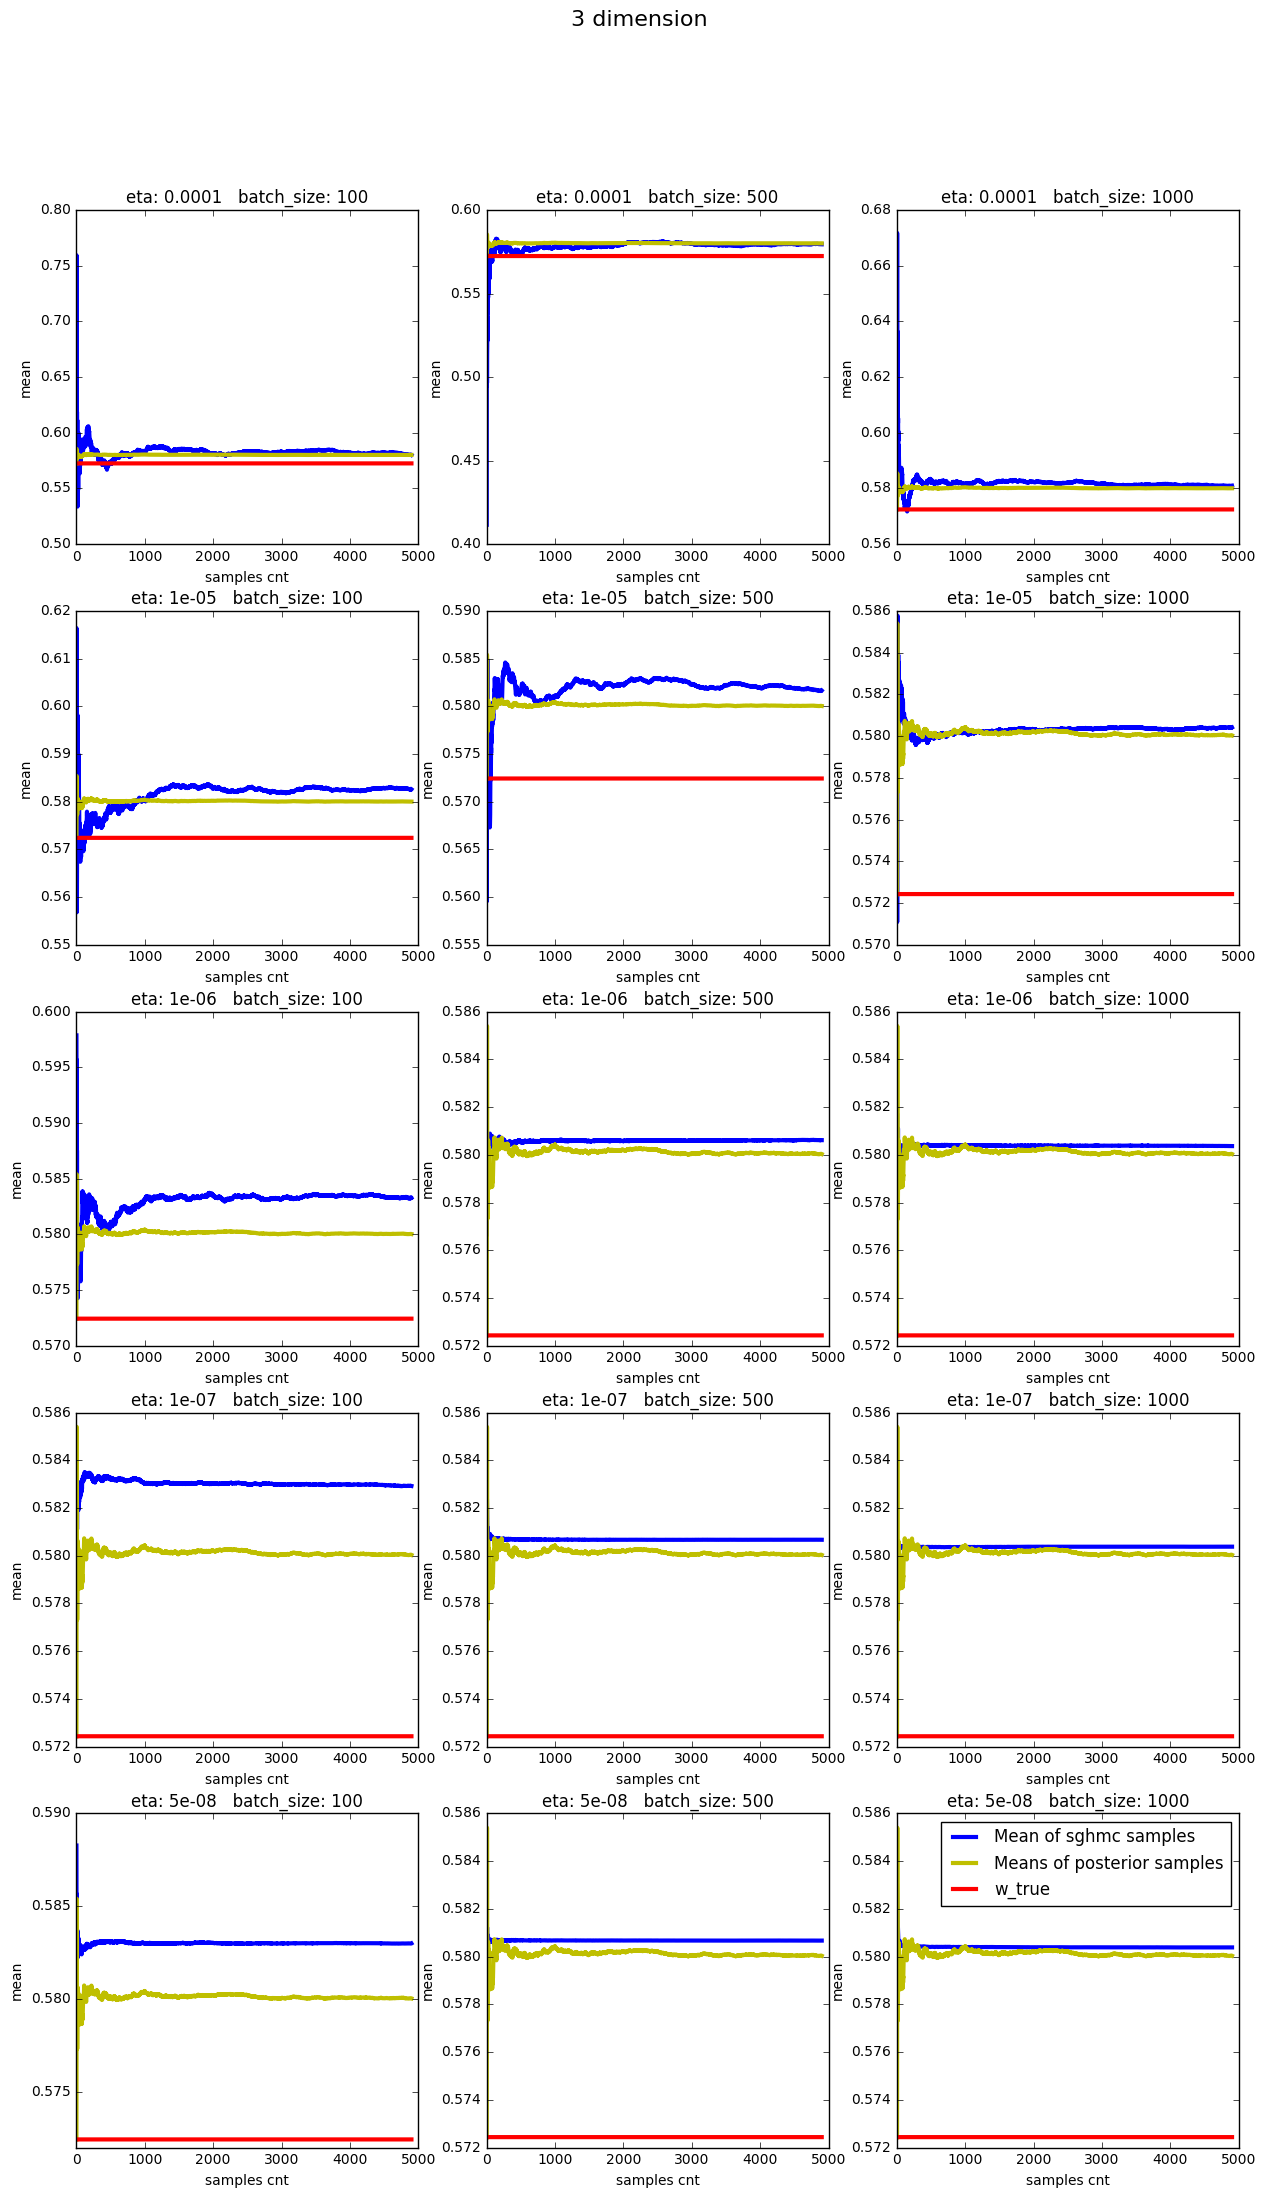

In [759]:
f, axxr = plt.subplots(5, 3)
f.set_figheight(25)
f.set_figwidth(15)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100, 500, 1000]
means_posterior = np.cumsum(w_posterior, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        samples_cnt = samples_2[i, j, 100:, :].shape[0]
        #calculate means
        means_sghmc = np.cumsum(samples_2[i, j, 100:, :], axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        
        #axxr[i, j].set_yscale('log')
        
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_sghmc[:, 2], lw=3, c='b')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_posterior[:, 2], lw=3, c='y')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), w_true[2] * np.ones(samples_cnt), lw=3, c='r')
        
        axxr[i, j].set_xlabel('samples cnt')
        axxr[i, j].set_ylabel('mean')
plt.legend(['Mean of sghmc samples',
            'Means of posterior samples',
           'w_true'])
f.suptitle('3 dimension', fontsize=16)

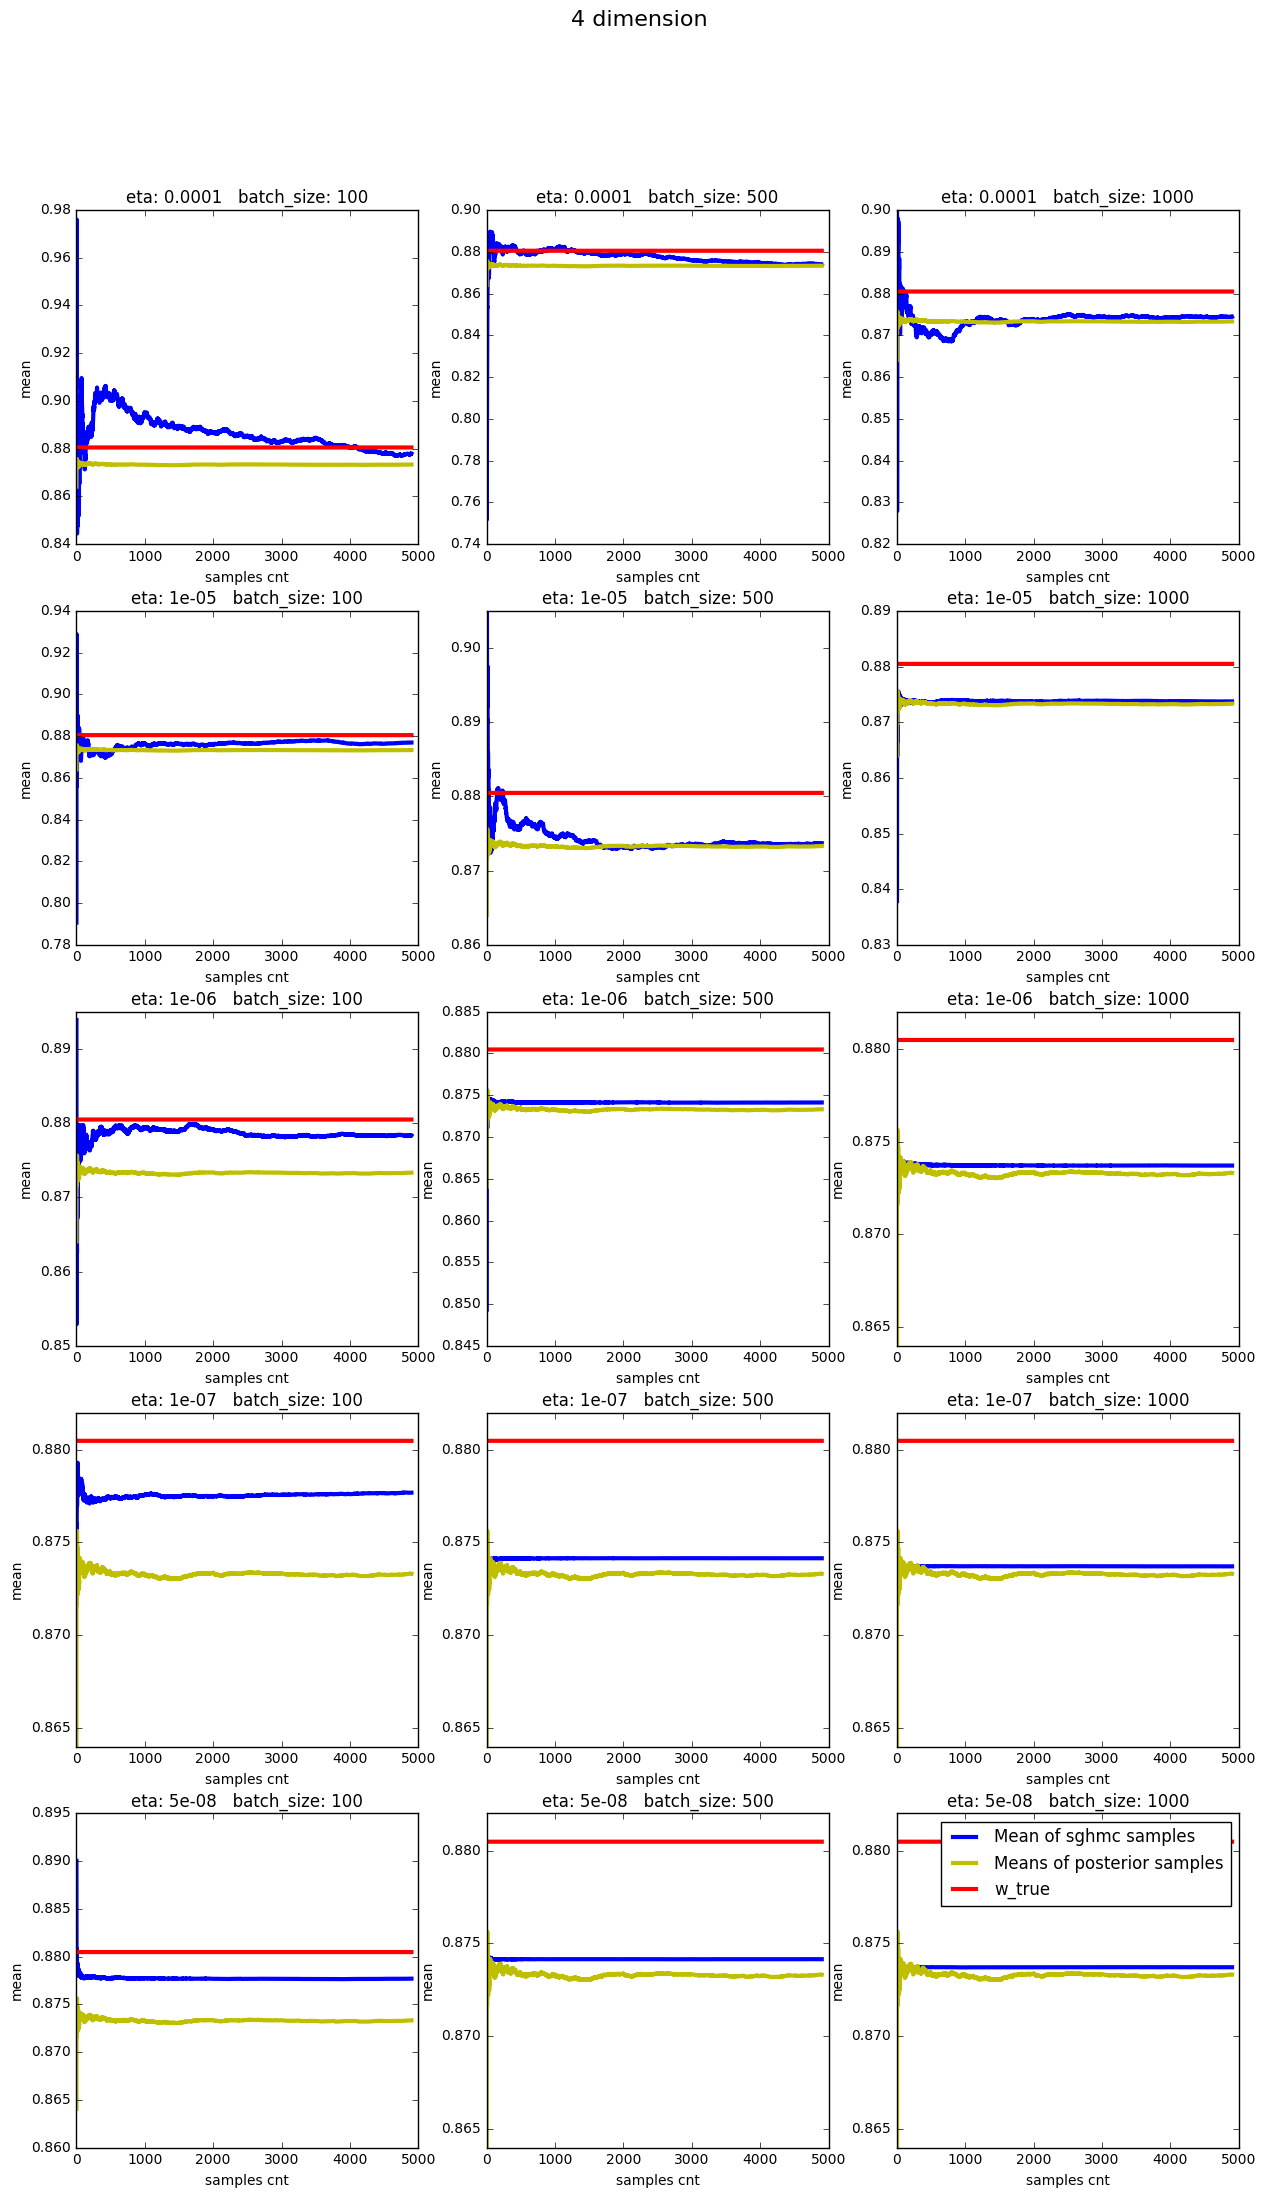

In [760]:
f, axxr = plt.subplots(5, 3)
f.set_figheight(25)
f.set_figwidth(15)
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100, 500, 1000]
means_posterior = np.cumsum(w_posterior, axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        samples_cnt = samples_2[i, j, 100:, :].shape[0]
        #calculate means
        means_sghmc = np.cumsum(samples_2[i, j, 100:, :], axis=0) / np.arange(1, samples_cnt + 1)[:, np.newaxis]
        
        #axxr[i, j].set_yscale('log')
        
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_sghmc[:, 3], lw=3, c='b')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), means_posterior[:, 3], lw=3, c='y')
        axxr[i, j].plot(np.arange(1, samples_cnt + 1), w_true[3] * np.ones(samples_cnt), lw=3, c='r')
        
        axxr[i, j].set_xlabel('samples cnt')
        axxr[i, j].set_ylabel('mean')
plt.legend(['Mean of sghmc samples',
            'Means of posterior samples',
           'w_true'])
f.suptitle('4 dimension', fontsize=16)

### Frobenius norm between true posterior covarince matrix and sample covariance.

In [767]:
eta_params = [1e-4, 1e-5, 1e-6, 1e-7, 5e-8]
batch_size_params = [100, 500, 1000]

frob_norm = np.zeros((len(eta_params), len(batch_size_params)))
for i in range(len(eta_params)):
    for j in range(len(batch_size_params)):
        frob_norm[i, j] = np.sqrt(((cov_w_X - np.cov(samples_2[i, j, 100:, :].T)) ** 2).sum())

In [776]:
[0] + list(frob_norm[0, :])

[0, 0.099165281061381519, 0.019049667090126517, 0.0089119540781382733]

In [779]:
column = ['eta'] + batch_size_params
frob_dataframe = pd.DataFrame(columns=column)
for i, eta in enumerate(eta_params):
    row = [eta] + list(frob_norm[i, :])
    frob_dataframe = frob_dataframe.append(pd.Series(
                                            row,
                                            index=frob_dataframe.columns),
                                            ignore_index=True)

In [780]:
frob_dataframe

,eta,100,500,1000
0,1.000000e-04,0.099165,0.019050,0.008912
1,1.000000e-05,0.011199,0.002058,0.000536
2,1.000000e-06,0.004758,0.000061,0.000162
3,1.000000e-07,0.000025,0.000194,0.000199
4,5.000000e-08,0.000082,0.000198,0.000200


## Gaussian.

$$p(w) = \mathcal{N}(w|\mu, C_w)$$
$$p(x|w) = \mathcal{N}(x|w, C_{x|w})$$
$$p(w|X) \propto p(w)p(X|w)$$
$$N=10000$$

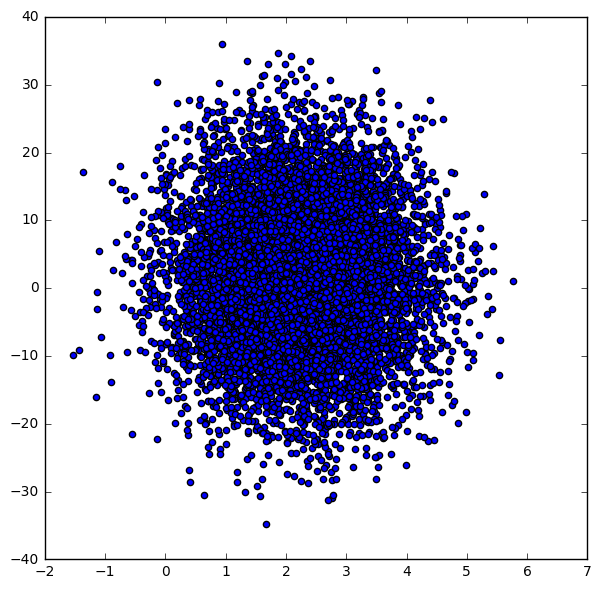

In [1046]:
num_features = 2
num_objects = 10000
cov_w = np.zeros((num_features, num_features))
mu_w = np.array([1, 2])
cov_w[0, 0] = 1
cov_w[0, 1] = cov_w[1, 0] = 0
cov_w[1, 1] = 100
#1 2
#2 100

cov_x_w = np.zeros((num_features, num_features))
cov_x_w[0, 0] = 1
cov_x_w[1, 0] = cov_x_w[0, 1] = 0
cov_x_w[1, 1] = 100


w_true = np.random.multivariate_normal(mu_w, cov_w)
X = np.random.multivariate_normal(w_true, cov_x_w, size=num_objects)

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c='b')

In [1047]:
cov_w_inv = np.linalg.inv(cov_w)
cov_x_w_inv = np.linalg.inv(cov_x_w)

In [1048]:
def grad(w, X):
    return cov_w_inv.dot(w - mu_w) - cov_x_w_inv.dot((X - w).sum(axis=0))

### True posterior.

$$C_{w|X} = (C_w^{-1} + N C_{x|w}^{-1})^{-1}$$
$$\mu_{w|X} = C_{w|X}\Big( C^{-1}_w \mu_{w} + C^{-1}_{x|w} \big(\sum_{i=1}^N x_i\big)\Big)$$

In [1049]:
cov_w_x = np.linalg.inv(cov_w_inv + num_objects * cov_x_w_inv)
mu_w_x = cov_w_x.dot(cov_w_inv.dot(mu_w) + cov_x_w_inv.dot(X.sum(axis=0)))

w_posterior = np.random.multivariate_normal(mu_w_x, cov_w_x, size=4000)

### Samples from SGHMC.

In [1050]:
%%time
eta_params = np.array([1e-5, 0.8e-5, 0.6e-5, 0.4e-5, 0.2e-5, 1e-6])
batch_size_params = [500]
epoch_cnt = 5000
w_start = np.random.multivariate_normal(mu_w, cov_w)
w_start = mu_w_x
samples_3 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=0.01, epochs=epoch_cnt, batch_size=batch_size, seed=417)
        batch_cnt = num_objects // batch_size
        samples_3[i, j, :, :] = sampler.samples_return(X, w_init=w_start)[::batch_cnt, :]
    print("eta: ", eta)

eta:  1e-05
eta:  8e-06
eta:  6e-06
eta:  4e-06
eta:  2e-06
eta:  1e-06
CPU times: user 1min 37s, sys: 26.6 ms, total: 1min 37s
Wall time: 1min 37s


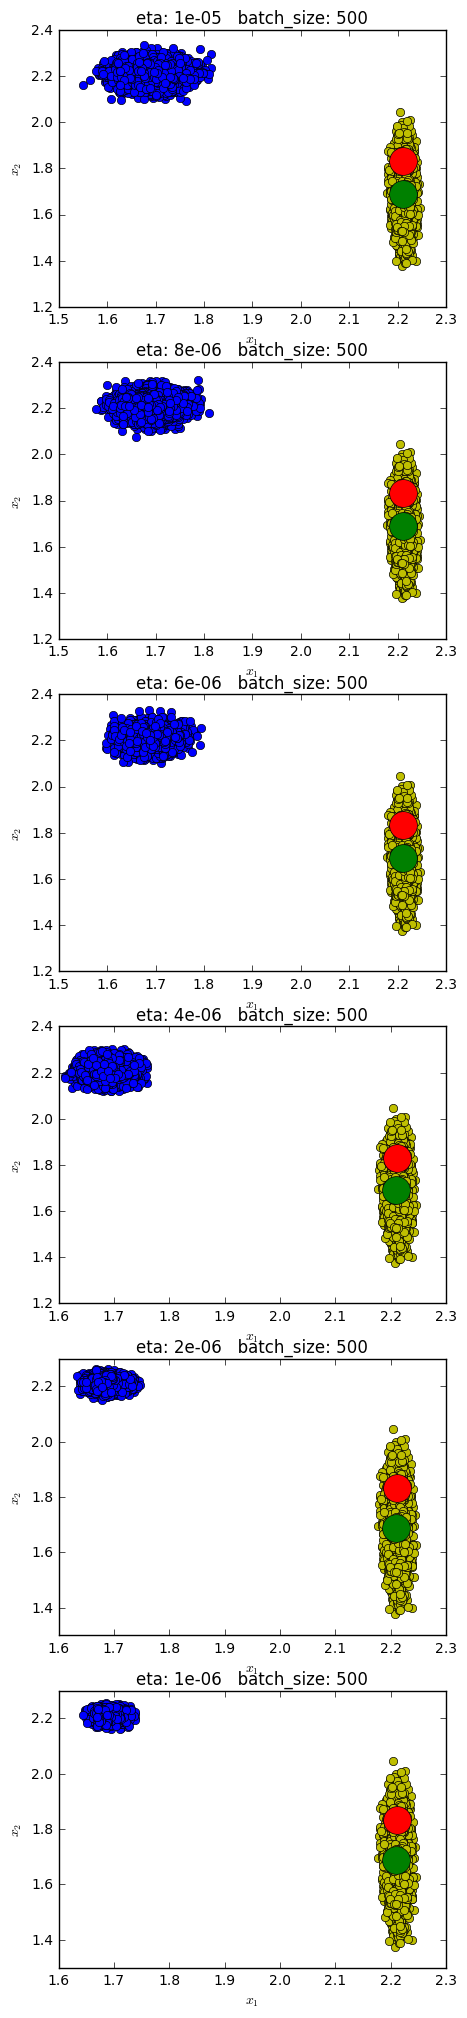

In [1053]:
f, axxr = plt.subplots(6, 1)
f.set_figheight(25)
f.set_figwidth(5)
#eta_params = [1e-5, 0.8e-5, 0.6e-5, 0.4e-5, 0.2e-5, 1e-6]
batch_size_params = [500]
epoch_cnt = 5000

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        
        axxr[i].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        axxr[i].plot(w_posterior[:, 0], w_posterior[:, 1], 'yo')
        axxr[i].plot(samples_3[i, j, 100:, 1], samples_3[i, j, 100:, 0], 'bo')
        axxr[i].plot(w_true[0], w_true[1],'ro', markersize=20)
        sghmc_mean = samples_3[i, j, :, :].mean(axis=0)
        axxr[i].plot(sghmc_mean[0], sghmc_mean[1],'go', markersize=20)
        axxr[i].set_xlabel('$x_1$')
        axxr[i].set_ylabel('$x_2$')
#plt.legend(['True posterior', 
#            'SGHMC samples',
#           'w_true',
#           'sghmc mean'], bbox_to_anchor=(0.0, -0.5), prop={'size': 30})

## Bayesian Linear Regression.

$$p(w) = \mathcal{N}(w|0, I)$$
$$p(y|x, w) = \mathcal{N}(y|w^Tx, \epsilon I)$$
$$p(w|y, X) \propto p(w)p(y|X, w) $$

In [842]:
noise_var = 0.1
num_objects = 1000
num_features = 1
prior_var = 1.

X = np.random.randn(num_objects, num_features)
w_true = (np.random.randn(num_features) * np.sqrt(prior_var))[0]
noise = np.random.randn(num_objects, 1) * np.sqrt(noise_var)
y = (X.dot(w_true) + noise)[:, 0]

In [897]:
def grad(w, X, y):
    return -w + 1./noise_var * X.T.dot(X.dot(w) - y)

### True posterior.

$$C_{w|X} = (I + 1/ \epsilon X^T X)^{-1}$$
$$\mu_{w|X} = 1/ \epsilon C_{w|X} \sum_{i=1}^N y_i x_i$$

In [844]:
cov_w_x = np.linalg.inv(np.eye(num_features) + 1. / noise_var * X.T.dot(X))
mu_w_x = 1. / noise_var * cov_w_x.dot((X * y[:, np.newaxis]).sum(axis=0))

### Samples from SGHMC.

In [899]:
%%time
eta_params = [1e-3, 1e-4, 1e-5, 1e-6, 5e-7]
batch_size_params = [10, 50, 100]
epoch_cnt = 5000
w_start = np.random.multivariate_normal(np.zeros(num_features), np.eye(num_features))
samples_4 = np.zeros((len(eta_params), len(batch_size_params), epoch_cnt, num_features))

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        sampler = SGHMC(grad, eta=eta, alpha=0.01, epochs=epoch_cnt, batch_size=batch_size)
        batch_cnt = num_objects // batch_size
        samples_4[i, j, :, :] = sampler.samples_return(X, w_init=w_start, y=y)[::batch_cnt, :]
    print("eta: ", eta)

eta:  0.001
eta:  0.0001
eta:  1e-05
eta:  1e-06
eta:  5e-07
CPU times: user 1min 20s, sys: 19.1 ms, total: 1min 20s
Wall time: 1min 20s


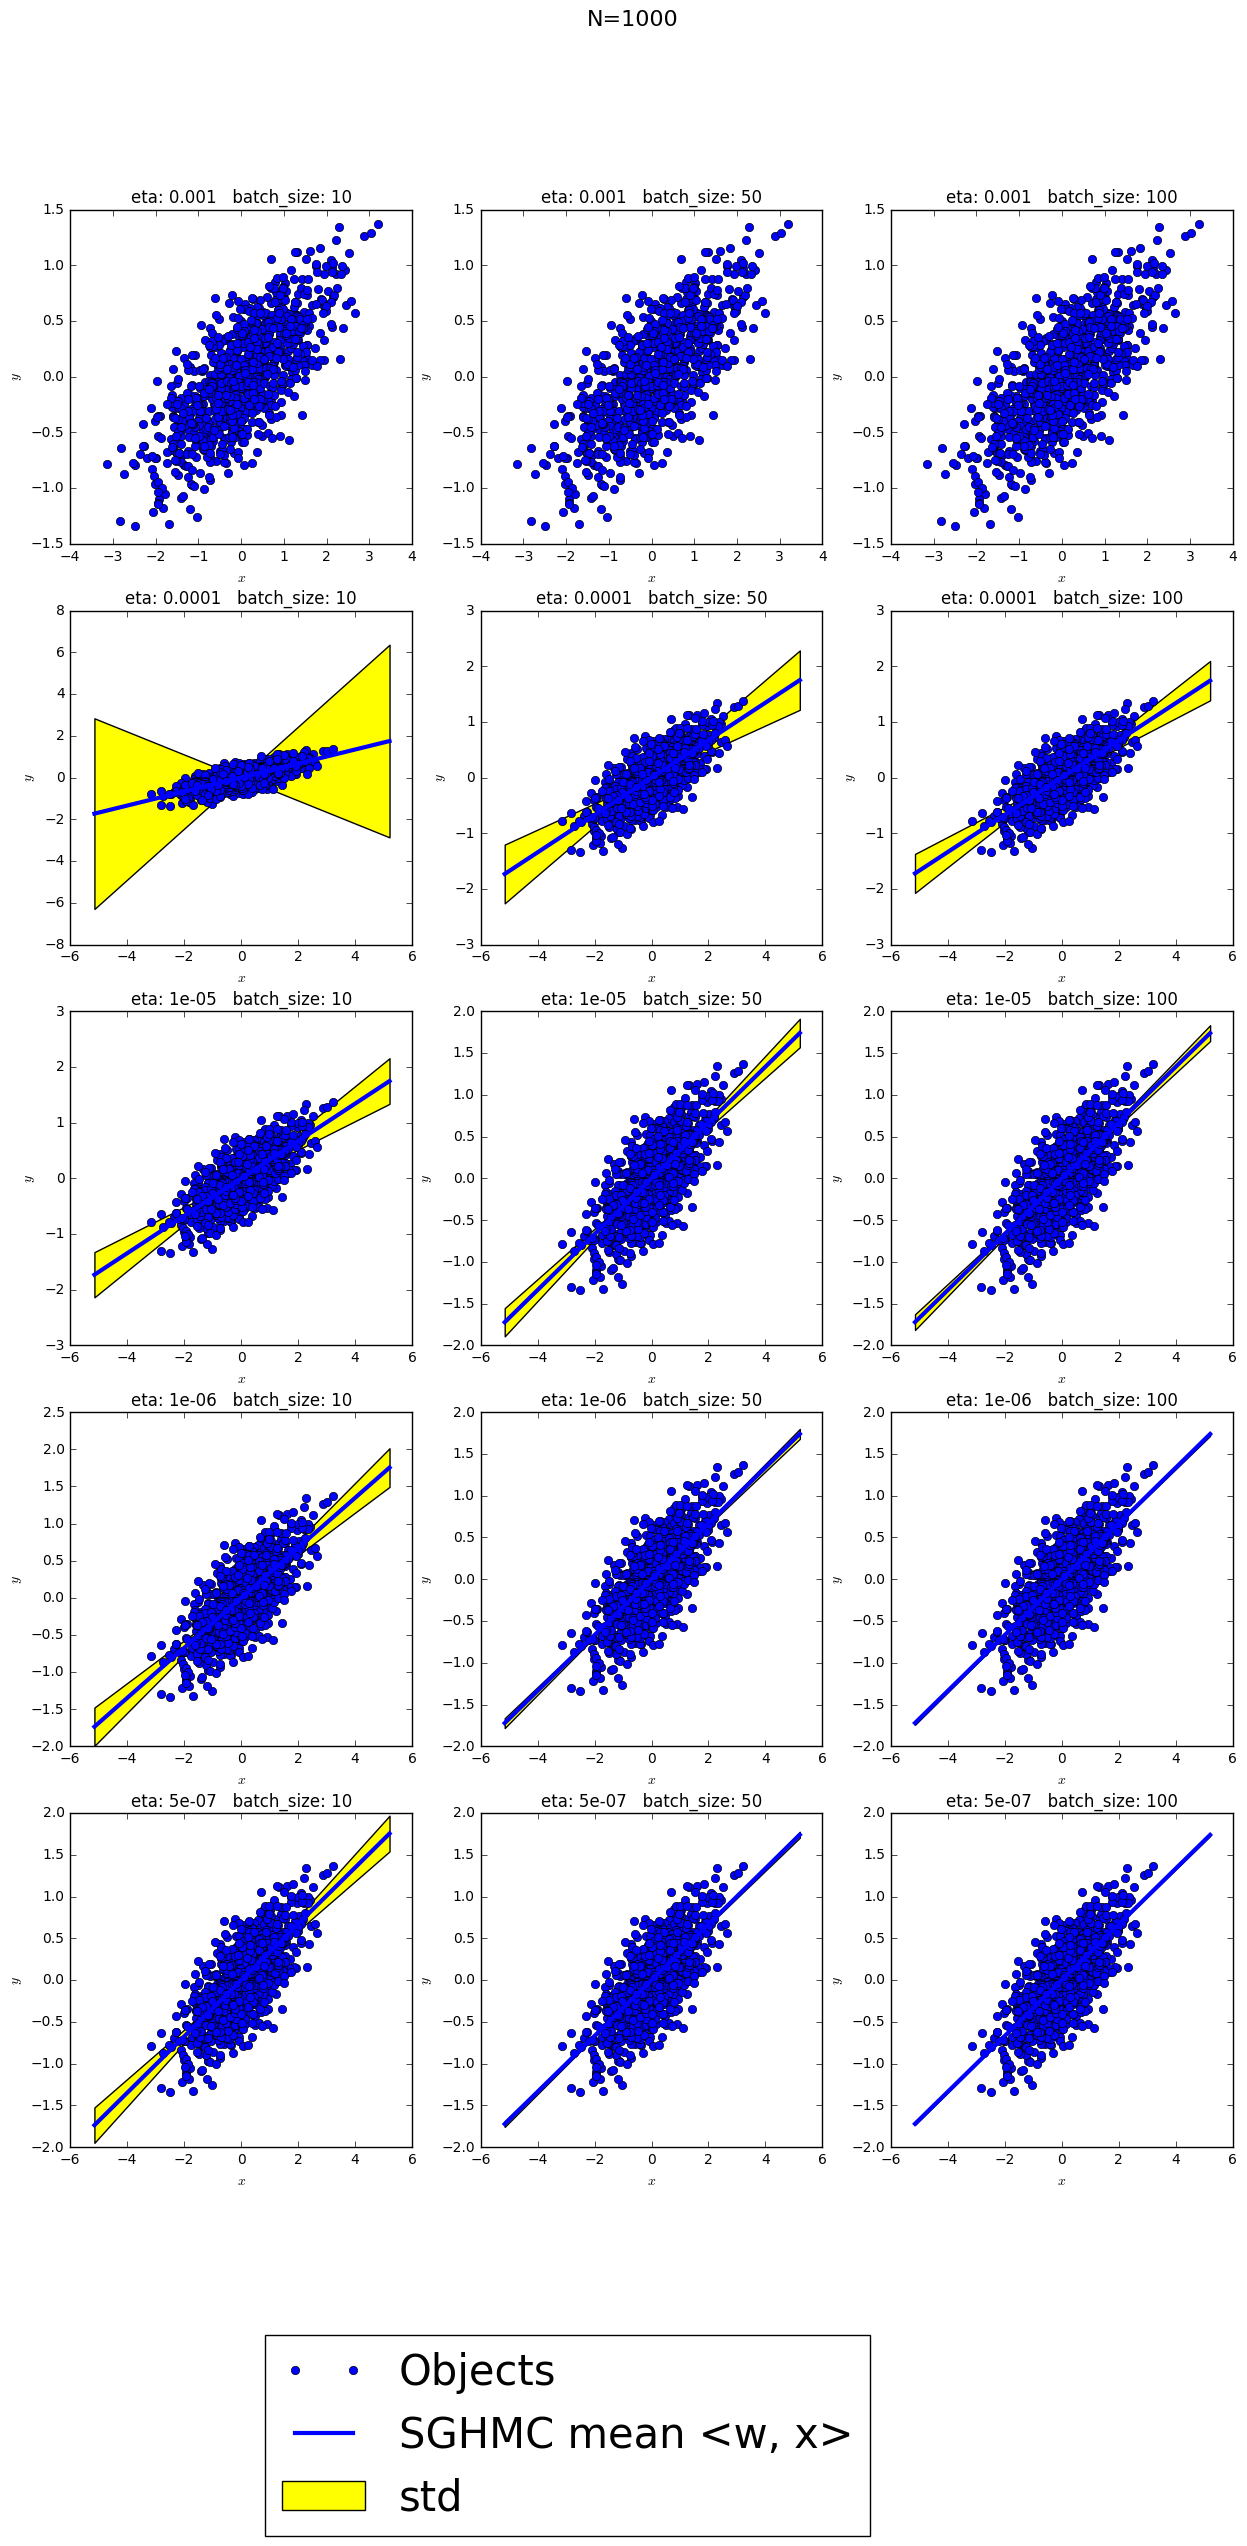

In [907]:
f, axxr = plt.subplots(5, 3)
f.set_figheight(25)
f.set_figwidth(15)
eta_params = [1e-3, 1e-4, 1e-5, 1e-6, 5e-7]
batch_size_params = [10, 50, 100]
epoch_cnt = 5000
n_grid = 100
x_grid = np.linspace(X.min() - 2, X.max() + 2, n_grid)

for i, eta in enumerate(eta_params):
    for j, batch_size in enumerate(batch_size_params):
        y_mean = []
        y_std = []
        y_true_mean = []
        y_true_std = []
        axxr[i, j].plot(X[:, 0], y, 'bo')
        for k in range(n_grid):
            y_mean.append((samples_4[i, j, 100:, :] * x_grid[k]).mean())
            y_std.append((samples_4[i, j, 100:, :] * x_grid[k]).std())
            y_true_std.append(cov_w_x[0, 0] * x_grid[k])
            y_true_mean.append(mu_w_x[0] * x_grid[k])
        y_std = np.array(y_std)
        y_mean = np.array(y_mean)
        y_true_std = np.array(y_true_std)
        y_true_mean = np.array(y_true_mean)
        
        axxr[i, j].plot(x_grid, y_mean, lw=3)
        #axxr[i, j].plot(x_grid, y_true_mean, lw=3, c='r')
        
        axxr[i, j].fill_between(x_grid, y_mean + y_std, y_mean - y_std, facecolor='yellow')
        #axxr[i, j].fill_between(x_grid, y_true_mean + y_true_std, y_true_mean - y_true_std, facecolor='green')
        
        axxr[i, j].set_title("eta: " + str(eta) + "   batch_size: " + str(batch_size))
        
        axxr[i, j].set_xlabel('$x$')
        axxr[i, j].set_ylabel('$y$')
plt.legend(['Objects', 
            'SGHMC mean <w, x>',
           'std'], bbox_to_anchor=(0.0, -0.5), prop={'size': 30})
f.suptitle('N=1000', fontsize=16)

In [ ]:
noise_var = 0.1
num_objects = 1000
num_features = 1
prior_var = 1.

X = np.random.randn(num_objects, num_features)
w_true = (np.random.randn(num_features) * np.sqrt(prior_var))[0]
noise = np.random.randn(num_objects, 1) * np.sqrt(noise_var)
y = (X.dot(w_true) + noise)[:, 0]